In [1]:
import os
os.environ['TEJAPI_KEY'] = "Yourkey"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

import pandas as pd
import numpy as np


from zipline.pipeline import Pipeline
from logbook import Logger, StderrHandler, INFO

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2020-01-01'
end = '2023-12-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e =['Common Stock-Foreign', 'Common Stock'])
pool[:10]

[2024-12-24 06:54:12.727995]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_e': ['Common Stock-Foreign', 'Common Stock']}


Currently used TEJ API key call quota 158/100000 (0.16%)
Currently used TEJ API key data quota 74759386/10000000 (747.59%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210']

In [3]:
start_dt = pd.Timestamp(start, tz='utc')
end_dt = pd.Timestamp(end, tz='utc')

tickers = ' '.join(pool)

os.environ['mdate'] = start+' '+end
os.environ['ticker'] = tickers+' IR0001'

In [4]:
!zipline ingest -b tquant

In [5]:
import tejapi

# 從 API 取得 TWN/APIBSTN1 董監全體持股狀況
data = tejapi.fastget(
    'TWN/APIBSTN1',
    coid=pool,
    mdate={'gte':pd.Timestamp(start) - pd.DateOffset(months=3), 'lte':pd.Timestamp(end)},
    opts={'columns':['coid','mdate','fld005','fld005l']},
    paginate=True
).rename(columns={'fld005': 'Director_and_Supervisor_Holdings_Percentage',
                  'fld005l': 'Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period'})

# 計算 The_Month_Before_Last （前一期的`與前期董監持股差異％` fld005l）
shift_data = (
    data[['coid','mdate','Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period']].
    rename(columns={'Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period':'The_Month_Before_Last'})
)
shift_data['mdate'] = shift_data['mdate'] + pd.DateOffset(months=1)

data = data.merge(shift_data,on=['coid','mdate'], how='left')

# 董監持股比例須於每月 15 日前公布上個月的數據，因此先將 mdate（年月）先轉成名目每月十五號（均為次月十五號）
data['mdate'] = data['mdate'] + pd.DateOffset(months=1)
data['mdate'] = data['mdate'].apply(lambda x: x.replace(day=15))

# 將 NA 值替換為 'N/A'，避免後續 ffill 時填補到前一期資料
for i in ['Director_and_Supervisor_Holdings_Percentage',
          'Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period',
          'The_Month_Before_Last']:
    data[i] = np.where(data[i].isnull(), 'N/A', data[i])

In [6]:
# 生成每間公司所有日曆日的 DataFrame
days = pd.date_range(pd.Timestamp(start) - pd.DateOffset(months=2), end).tolist()
df_tradeday = pd.DataFrame({
        'coid':[tick for tick in pool for day in days],
        'mdate':days * len(pool)
    })

# 將 df_tradeday 合併 API 資料，並 foward ffill，同時把 'N/A' 替換回 np.nan
data = (
    df_tradeday.
    merge(data,on=['coid','mdate'], how='left').
    set_index(['coid','mdate']).
    sort_index().
    groupby(['coid']).
    ffill().
    reset_index().
    replace({'N/A': np.nan})
)

In [7]:
data[data.mdate>='2020-01-01'].head()

,coid,mdate,Director_and_Supervisor_Holdings_Percentage,Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period,The_Month_Before_Last
61,1101,2020-01-01,14.31,0.0,0.0
62,1101,2020-01-02,14.31,0.0,0.0
63,1101,2020-01-03,14.31,0.0,0.0
64,1101,2020-01-04,14.31,0.0,0.0
65,1101,2020-01-05,14.31,0.0,0.0


In [8]:
from zipline.data import bundles

bundle = bundles.load('tquant')

sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

# shift(1): 15 號公告的資料 16 號才能用，避免前視偏誤
transform_data = data.set_index(['coid', 'mdate']).unstack('coid').shift(1)
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data.tail()

Director_and_Supervisor_Holdings_Percentage          
coid                                                             0      1      
mdate                                                                          
2023-12-27 00:00:00+00:00                                        7.48  27.36  \
2023-12-28 00:00:00+00:00                                        7.48  27.36   
2023-12-29 00:00:00+00:00                                        7.48  27.36   
2023-12-30 00:00:00+00:00                                        7.48  27.36   
2023-12-31 00:00:00+00:00                                        7.48  27.36   

                                                                    
coid                                     2      3     4      5      
mdate                                                               
2023-12-27 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37  \
2023-12-28 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-29 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-30 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   
2023-12-31 00:00:00+00:00  17.150000000000002  24.14  3.95  36.37   

                                                                   ...   
coid                                     6      7      8     9     ...   
mdate                                                              ...   
2023-12-27 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...  \
2023-12-28 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-29 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-30 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   
2023-12-31 00:00:00+00:00  31.400000000000002  14.55  28.84  13.0  ...   

                          The_Month_Before_Last                                 
coid                                       1855 1856 1857 1858 1859 1860 1861   
mdate                                                                           
2023-12-27 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  \
2023-12-28 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-29 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-30 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-31 00:00:00+00:00                   0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                            
coid                        1862 1863 1864  
mdate                                       
2023-12-27 00:00:00+00:00  -0.06  0.0  0.0  
2023-12-28 00:00:00+00:00  -0.06  0.0  0.0  
2023-12-29 00:00:00+00:00  -0.06  0.0  0.0  
2023-12-30 00:00:00+00:00  -0.06  0.0  0.0  
2023-12-31 00:00:00+00:00  -0.06  0.0  0.0  

[5 rows x 5595 columns]

In [9]:
from zipline.pipeline.loaders.frame import DataFrameLoader
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period = Column(dtype=float)
    The_Month_Before_Last = Column(dtype=float)
    domain = TW_EQUITIES

inputs=[CustomDataset.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period,
        CustomDataset.The_Month_Before_Last]
Custom_loader = {i:DataFrameLoader(column=i, baseline=transform_data[i.name]) for i in inputs}
Custom_loader

{CustomDataset<TW>.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x2dd207ee350>,
 CustomDataset<TW>.The_Month_Before_Last::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x2dd207ee6d0>}

In [10]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.loaders import EquityPricingLoader

pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader, bundle.adjustment_reader)
def choose_loader(column):
    if column.name in EquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:
        return Custom_loader[column]
    else:
        raise Exception('Column not available')

engine = SimplePipelineEngine(
    get_loader = choose_loader,
    asset_finder = bundle.asset_finder,
    default_domain = TW_EQUITIES
)

In [11]:
def compute_signals():
    MOM1 = CustomDataset.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period.latest
    MOM2 = CustomDataset.The_Month_Before_Last.latest
    Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period_filter = \
        (CustomDataset.Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period.latest > 0)
    The_Month_Before_Last_filter = (CustomDataset.The_Month_Before_Last.latest > 0)

    mask = (Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period_filter & The_Month_Before_Last_filter)
    # 兩者都符合 >0 則表示連續兩月月增

    return Pipeline(columns={
        'MOM-1':MOM1,
        'MOM-1 是否為正':Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period_filter,
        'MOM-2':MOM2,
        'MOM-2 是否為正':The_Month_Before_Last_filter,
        'longs' : mask,
        },
    )

In [12]:
pipeline_result = engine.run_pipeline(compute_signals(), start, end)
pipeline_result.head()

MOM-1  MOM-1 是否為正  MOM-2   
2020-01-03 00:00:00+00:00 Equity(0 [1101])    0.0       False   0.00  \
                          Equity(1 [1102])    0.0       False   0.00   
                          Equity(2 [1103])    0.0       False   0.00   
                          Equity(3 [1104])    0.0       False   0.00   
                          Equity(4 [1108])    0.0       False   0.39   

                                            MOM-2 是否為正  longs  
2020-01-03 00:00:00+00:00 Equity(0 [1101])       False  False  
                          Equity(1 [1102])       False  False  
                          Equity(2 [1103])       False  False  
                          Equity(3 [1104])       False  False  
                          Equity(4 [1108])        True  False

In [13]:
pipeline_result.query("longs == 1")

MOM-1  MOM-1 是否為正  MOM-2   
2020-01-03 00:00:00+00:00 Equity(104 [1474])    0.37        True   0.01  \
                          Equity(117 [1517])    0.08        True   0.05   
                          Equity(128 [1531])    0.01        True   0.15   
                          Equity(129 [1532])    0.05        True   0.04   
                          Equity(234 [2006])    0.15        True   0.21   
...                                              ...         ...    ...   
2023-12-29 00:00:00+00:00 Equity(1746 [8401])   0.03        True   0.02   
                          Equity(1772 [8442])   1.17        True   0.23   
                          Equity(1784 [8472])   0.05        True   0.10   
                          Equity(1806 [8927])   0.61        True   0.26   
                          Equity(1847 [9935])   0.01        True   0.03   

                                               MOM-2 是否為正  longs  
2020-01-03 00:00:00+00:00 Equity(104 [1474])         True   True  
                          Equity(117 [1517])         True   True  
                          Equity(128 [1531])         True   True  
                          Equity(129 [1532])         True   True  
                          Equity(234 [2006])         True   True  
...                                                   ...    ...  
2023-12-29 00:00:00+00:00 Equity(1746 [8401])        True   True  
                          Equity(1772 [8442])        True   True  
                          Equity(1784 [8472])        True   True  
                          Equity(1806 [8927])        True   True  
                          Equity(1847 [9935])        True   True  

[65124 rows x 5 columns]

In [14]:
# idx = pd.IndexSlice
# pipeline_result.loc[idx['2022-02-01':'2022-02-27', bundle.asset_finder.lookup_symbols(['2330'], as_of_date=None),:]]

In [15]:
# pipeline_result[pipeline_result.Dire.isnull()].index.get_level_values(1).unique()

# 正式開始回測

In [16]:
# 取出所有交易日
from zipline.utils.calendar_utils import get_calendar 
cal = get_calendar('TEJ').all_sessions
cal = cal[(cal >= '2020-01-01') & (cal <= '2023-12-31')]
cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

In [17]:
# 計算每個交易日距離每月16日的距離
cal = pd.DataFrame(cal).rename(columns={0:'date'})
cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=x.month, day=16, tz='UTC'))
cal.tail(10)

,date,diff
964,2023-12-18 00:00:00+00:00,2 days
965,2023-12-19 00:00:00+00:00,3 days
966,2023-12-20 00:00:00+00:00,4 days
967,2023-12-21 00:00:00+00:00,5 days
968,2023-12-22 00:00:00+00:00,6 days
969,2023-12-25 00:00:00+00:00,9 days
970,2023-12-26 00:00:00+00:00,10 days
971,2023-12-27 00:00:00+00:00,11 days
972,2023-12-28 00:00:00+00:00,12 days
973,2023-12-29 00:00:00+00:00,13 days


In [18]:
# 篩選出平衡日期（取每月16日（含）後的第一個交易日），並轉為字串
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.month]).apply(lambda x: x[x['diff'].ge(pd.Timedelta(days=0))].head(1)).date.tolist()
tradeday = [str(i.date()) for i in tradeday]
tradeday[-5:]

['2023-08-16', '2023-09-18', '2023-10-16', '2023-11-16', '2023-12-18']

In [19]:
from zipline.algo.pipeline_algo import *

algo = TargetPercentPipeAlgo(
    start_session=start_dt,
    end_session=end_dt,
    capital_base=1e6,
    tradeday=tradeday,
    max_leverage=1,
    slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01),
    pipeline=compute_signals,
    custom_loader = Custom_loader
)

results = algo.run()

[2024-12-24 06:54:37.886000]: INFO: earn_dividends: Equity(1433 [6412]), cash_dividend amount: 3.1999999999999997, pay_date: 2020-05-14, div_owed: 787.1999999999999
[2024-12-24 06:54:39.484004]: INFO: handle_split: after split: asset: Equity(1207 [5469]), amount: 205, cost_basis: 39.31, last_sale_price: 39.35
[2024-12-24 06:54:39.485003]: INFO: handle_split: returning cash: 9.9
[2024-12-24 06:54:46.219012]: INFO: handle_split: after split: asset: Equity(927 [4152]), amount: 120, cost_basis: 70.21, last_sale_price: 71.9
[2024-12-24 06:54:46.220013]: INFO: handle_split: returning cash: 54.25
[2024-12-24 06:54:46.428015]: INFO: earn_dividends: Equity(1240 [5543]), cash_dividend amount: 0.7999999999999999, pay_date: 2020-07-03, div_owed: 341.59999999999997
[2024-12-24 06:54:46.429016]: INFO: earn_dividends: Equity(1720 [8213]), cash_dividend amount: 2.54668077, pay_date: 2020-07-03, div_owed: 621.39010788
[2024-12-24 06:54:46.626011]: INFO: earn_dividends: Equity(234 [2006]), cash_dividend

Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,20.04%
Cumulative returns,102.581%
Annual volatility,15.155%
Sharpe ratio,1.28
Calmar ratio,0.73
Stability,0.85
Max drawdown,-27.511%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.51,2020-01-20,2020-03-19,2020-06-05,89
1,16.55,2021-04-28,2021-05-17,2021-07-12,52
2,13.25,2022-08-31,2022-10-13,2023-02-23,116
3,12.43,2022-01-04,2022-07-01,2022-08-31,160
4,8.08,2021-07-26,2021-08-19,2021-11-09,74


Top 10 long positions of all time,max
sid,
4728,3.92%
2528,3.88%
6167,3.70%
5460,3.62%
6843,3.51%
8034,3.40%
6807,3.39%
6477,3.38%
2461,3.37%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
4728,3.92%
2528,3.88%
6167,3.70%
5460,3.62%
6843,3.51%
8034,3.40%
6807,3.39%
6477,3.38%
2461,3.37%


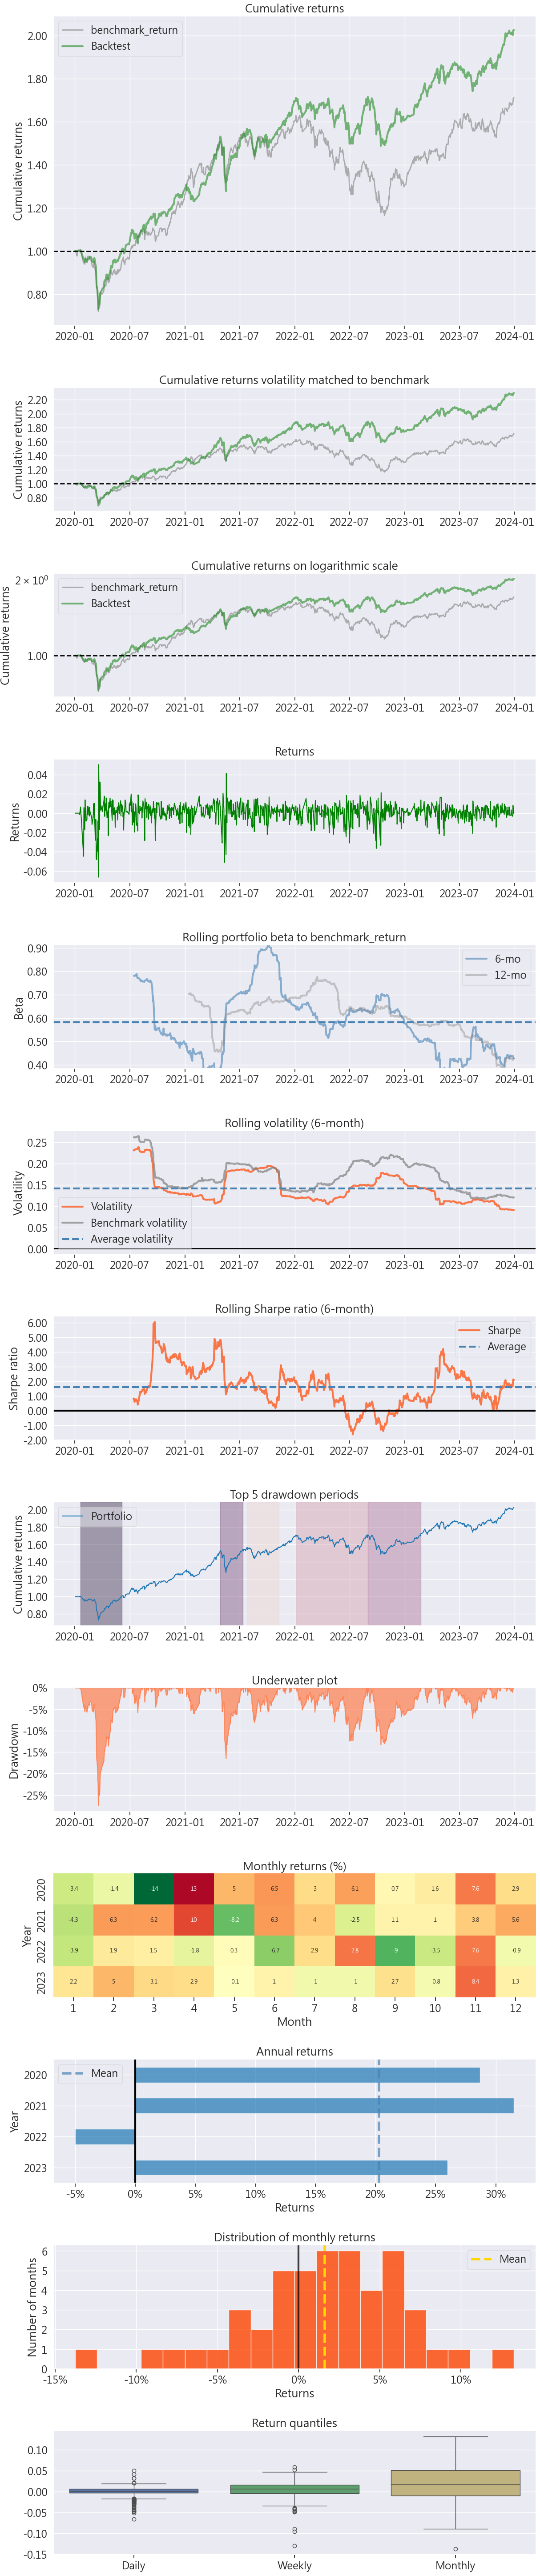

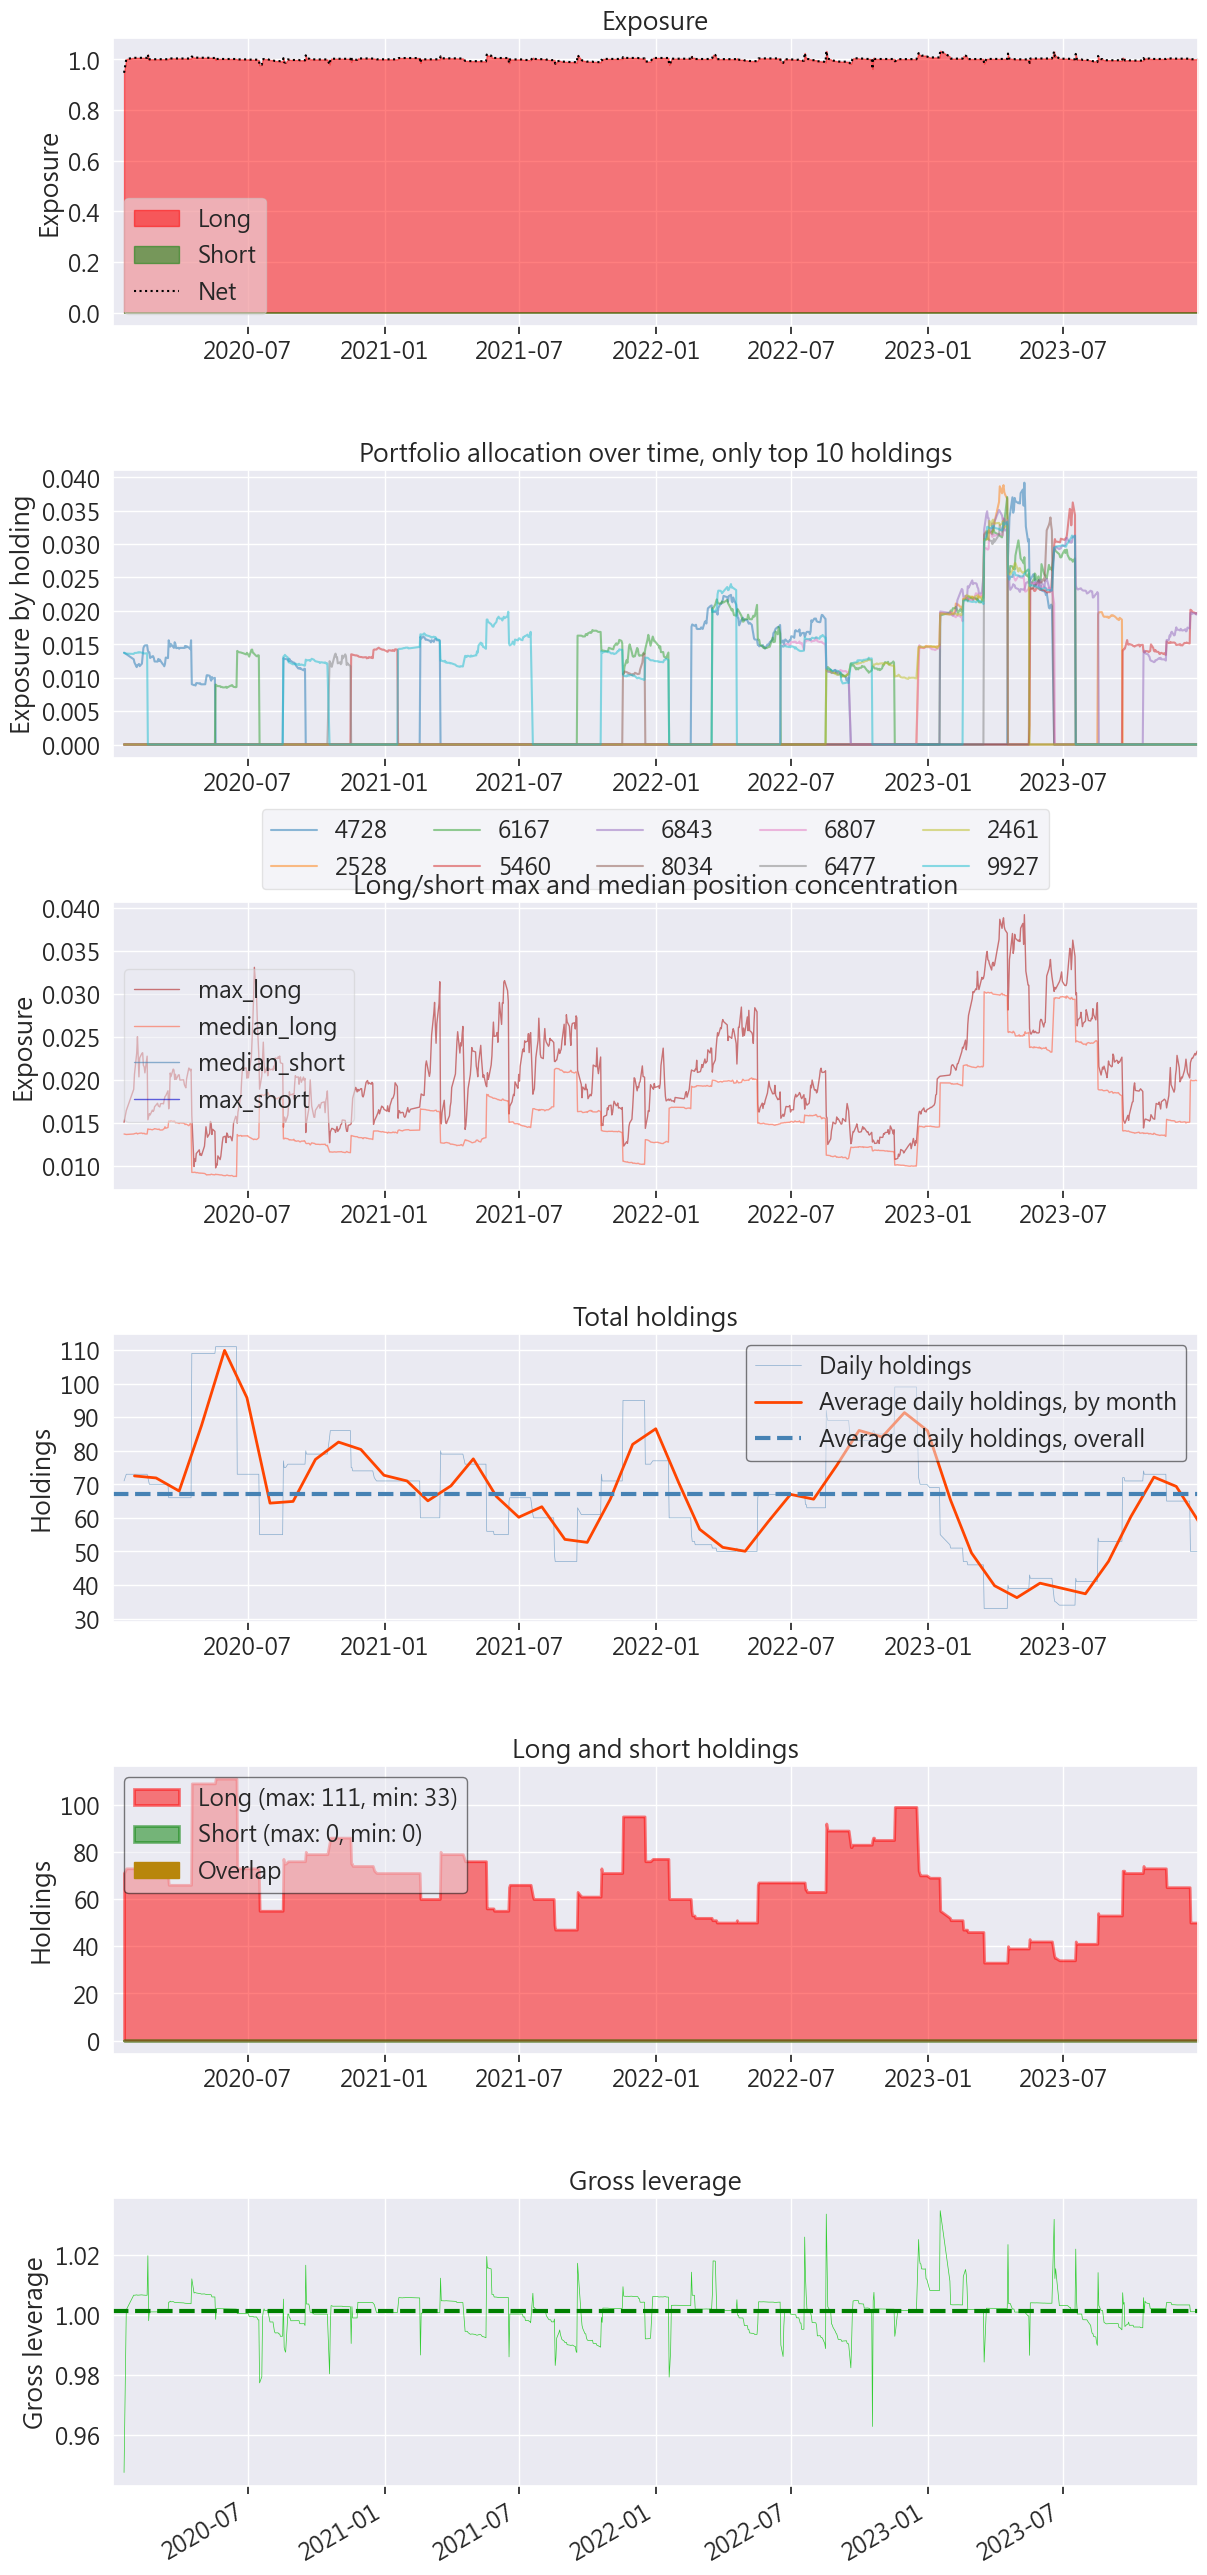

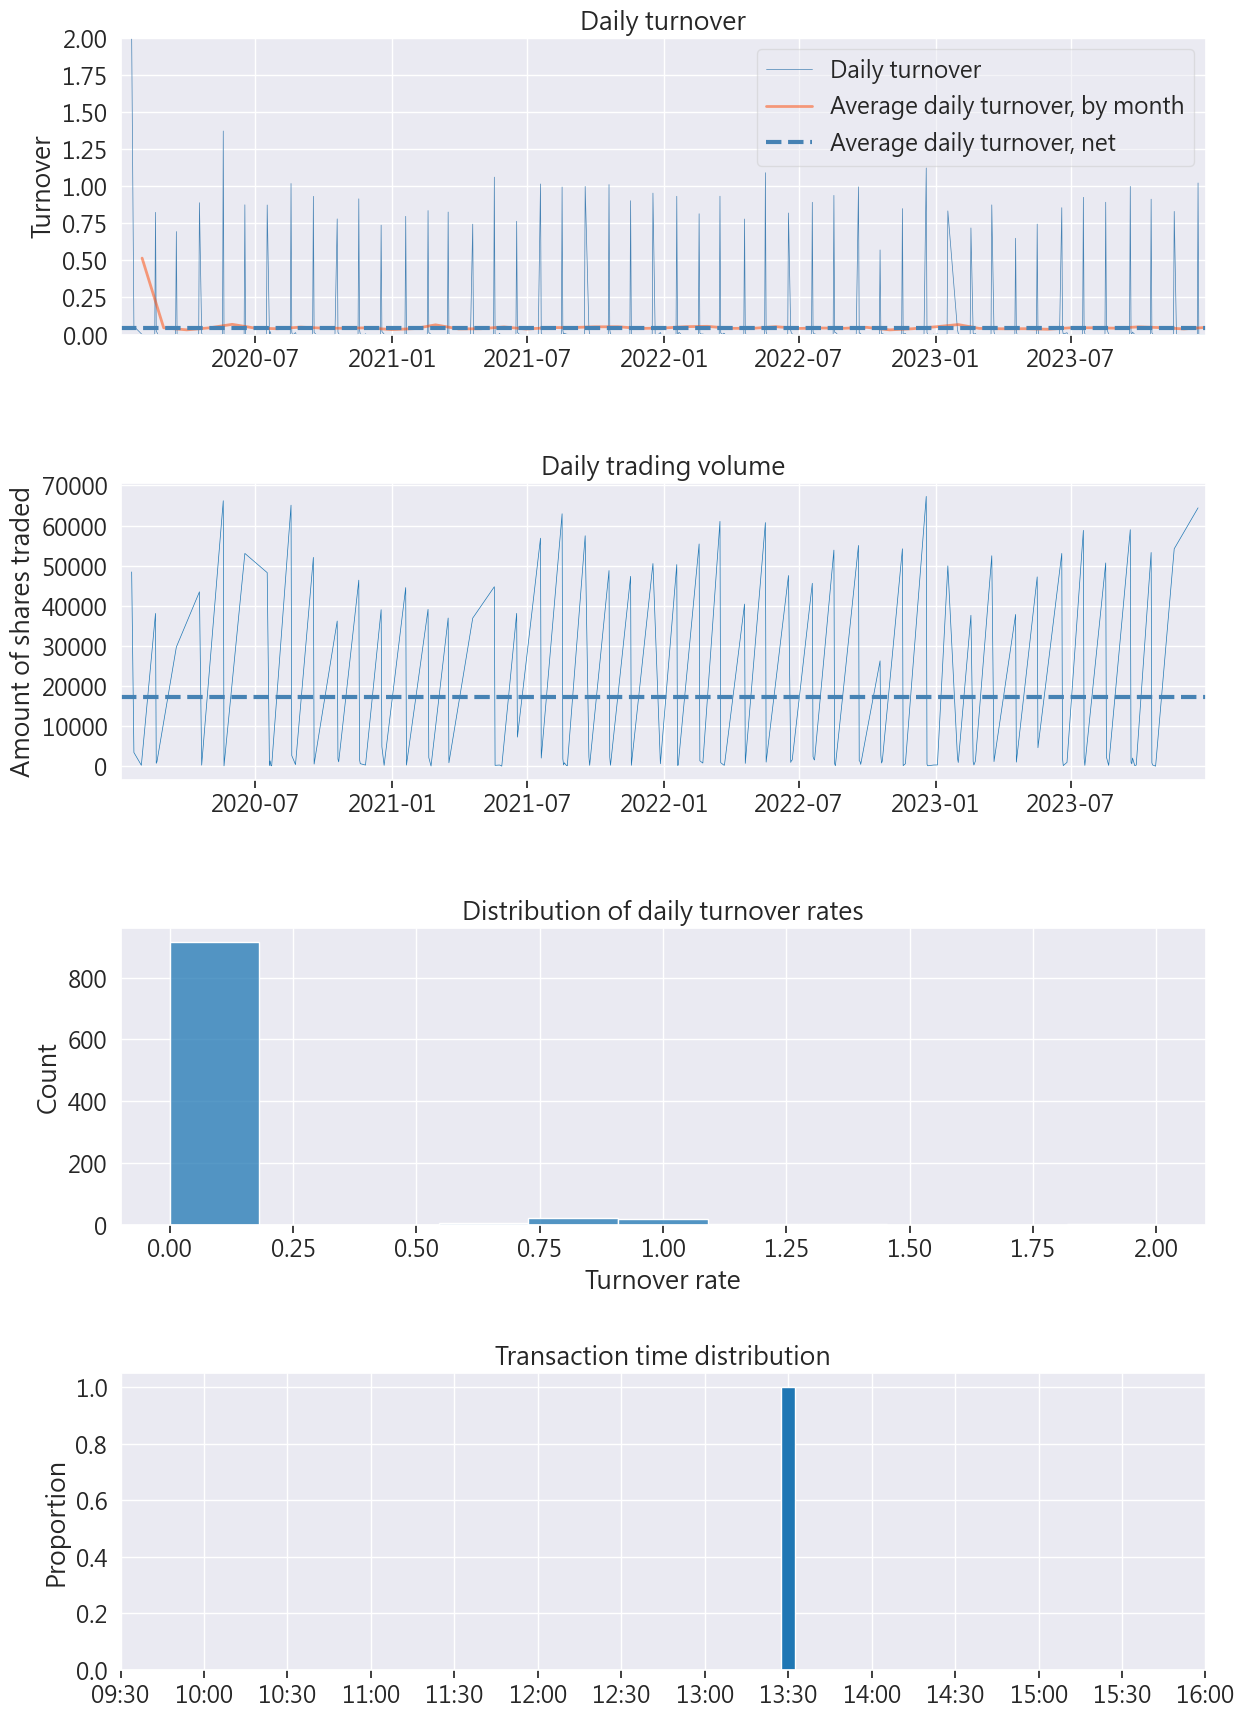

In [20]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(
    returns=returns,
    positions=positions,
    transactions=transactions,
    benchmark_rets=benchmark_rets
)

Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,14.931%
Cumulative returns,71.236%
Annual volatility,18.04%
Sharpe ratio,0.86
Calmar ratio,0.52
Stability,0.56
Max drawdown,-28.553%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.55,2020-01-14,2020-03-19,2020-07-06,112
1,28.47,2022-01-17,2022-10-25,2023-07-14,359
2,12.74,2021-04-27,2021-05-17,2021-06-28,43
3,8.25,2021-07-15,2021-08-20,2021-11-17,87
4,6.86,2023-07-28,2023-10-31,2023-11-17,77


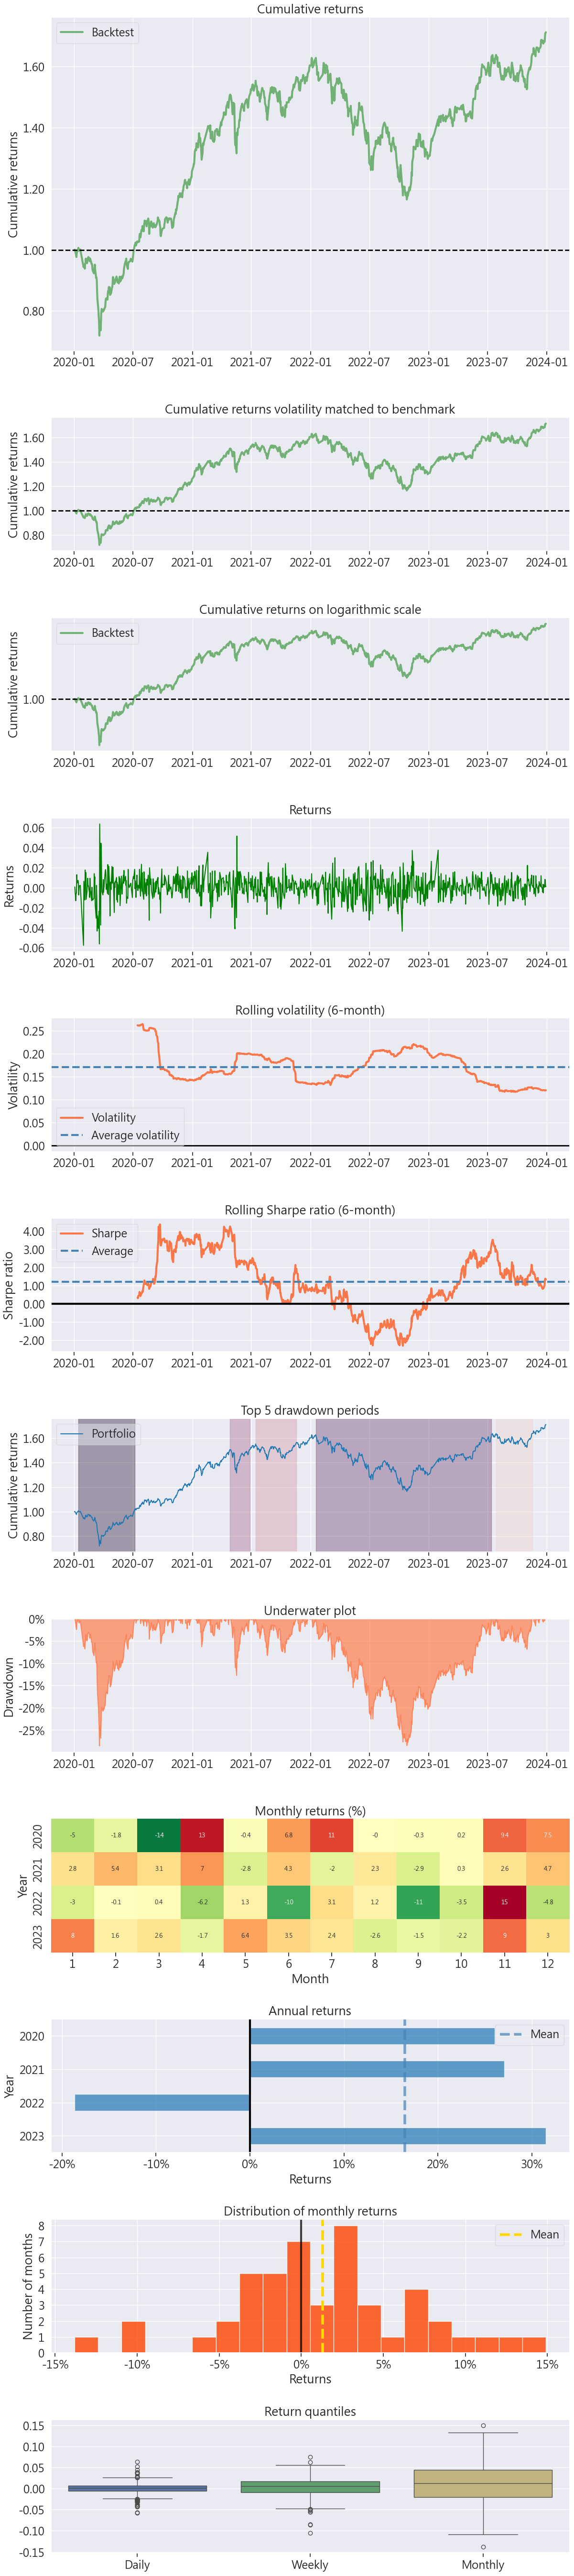

In [21]:
# pf.create_full_tear_sheet(returns=benchmark_rets)